
# Reinforcement Learning for Dynamic Pricing — **Stage 3 (Improved, with Stage 2 Reproduction)**

This notebook first **reproduces Stage 2** baselines and DQN variants, then applies **Stage 3** improvements:
- Reward: `profit - λ * price_variance`
- Soft target updates (τ = 0.005)
- Prioritized Replay Buffer (PER)
- Entropy bonus during action selection
- Dynamic price bands per SKU (median ± MAD)
- Horizon = 90

It outputs side-by-side **comparison tables and plots**.


In [1]:

# === Setup (Colab or Local) ===
!pip install -q xgboost==1.7.6 scikit-learn matplotlib torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.0 MB/s eta 0:00:00


In [2]:

import os, random, math, copy, time, json, re
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import torch, torch.nn as nn, torch.optim as optim
from collections import deque, namedtuple
import matplotlib.pyplot as plt

seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:

# === Google Drive mount (Colab) ===
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except Exception:
    print("Colab not detected; continuing without mounting.")
    IN_COLAB = False

# Preserve Stage-2 base_dir and file names
base_dir = "/content/drive/MyDrive/dataset"
sales_csv = os.path.join(base_dir, "Amazon Sale Report.csv")
if not os.path.exists(sales_csv):
    sales_csv = os.path.join(base_dir, "Sale Report.csv")

# Local fallback for offline execution (optional)
if not os.path.exists(sales_csv):
    local_candidates = [
        "./Amazon Sale Report.csv",
        "/mnt/data/Amazon Sale Report.csv",
        "./Sale Report.csv"
    ]
    for cand in local_candidates:
        if os.path.exists(cand):
            sales_csv = cand
            break

print("Using:", sales_csv, "Exists?", os.path.exists(sales_csv))


Mounted at /content/drive
Using: /content/drive/MyDrive/dataset/Amazon Sale Report.csv Exists? True


In [4]:

# === Load and Inspect ===
df = pd.read_csv(sales_csv, low_memory=False)
print("Loaded rows:", len(df))
print("Columns:", df.columns.tolist()[:80])

# --- Standardize expected columns ---
colmap = {c.lower().strip().replace(" ", "_"): c for c in df.columns}
def pick(*cands):
    for c in cands:
        k = c.lower().strip().replace(" ", "_")
        if k in colmap:
            return colmap[k]
    return None

price_col = pick("price", "selling_price", "sale_price", "unit_price")
qty_col   = pick("qty", "quantity", "units_sold", "order_quantity", "qty_ordered")
rev_col   = pick("revenue", "amount", "gross_revenue", "total")
sku_col   = pick("sku", "asin", "product_id", "item_sku")
date_col  = pick("date", "order_date", "invoice_date", "purchase_date")

print("Detected ->", dict(price=price_col, qty=qty_col, revenue=rev_col, sku=sku_col, date=date_col))

# Derive price if needed
if price_col is None and rev_col is not None and qty_col is not None:
    df["__price"] = (df[rev_col] / df[qty_col].replace(0, np.nan)).fillna(0)
    price_col = "__price"
    print("Derived price column ->", price_col)

# Valid rows only
if date_col is not None:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

# Status filter (if present)
if "Status" in df.columns:
    keep = [
        "Shipped", "Shipped - Delivered to Buyer", "Delivered"
    ]
    df = df[df["Status"].astype(str).isin(keep)]

# remove weird prices
df = df[(df[price_col] > 20) & (df[price_col] < 5000)]
df = df[(df[qty_col] >= 0)]

# Fallback SKU if missing
if sku_col is None:
    df["__sku"] = "ONE"
    sku_col = "__sku"

# Top 20 SKUs by volume
top_skus = df.groupby(sku_col)[qty_col].sum().sort_values(ascending=False).head(20).index.tolist()
df = df[df[sku_col].isin(top_skus)].copy()
print("SKUs kept:", len(top_skus), "->", top_skus[:10])
df.head(3)


Loaded rows: 128975
Columns: ['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ', 'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN', 'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city', 'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids', 'B2B', 'fulfilled-by', 'Unnamed: 22']
Detected -> {'price': None, 'qty': 'Qty', 'revenue': 'Amount', 'sku': 'SKU', 'date': 'Date'}
Derived price column -> __price
SKUs kept: 20 -> ['JNE3797-KR-L', 'JNE3797-KR-M', 'JNE3405-KR-L', 'JNE3797-KR-S', 'J0230-SKD-M', 'J0230-SKD-S', 'JNE3405-KR-S', 'JNE3797-KR-XL', 'JNE3797-KR-XS', 'SET268-KR-NP-XL']


/tmp/ipython-input-1800352705.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col], errors="coerce")


,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22,__price
7,7,406-7807733-3785945,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3405,JNE3405-KR-S,kurta,...,399.0,HYDERABAD,TELANGANA,500032.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN,399.0
28,28,405-7755803-4729935,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3567,JNE3567-KR-M,kurta,...,399.0,BENGALURU,KARNATAKA,560037.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN,NaN,399.0
39,39,403-4242957-8599555,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3405,JNE3405-KR-L,kurta,...,399.0,THIRUVANANTHAPURAM,KERALA,695011.0,IN,NaN,False,NaN,NaN,399.0


In [5]:

# === Feature Engineering ===
fe = df.copy()
if date_col is not None:
    fe["weekday"] = fe[date_col].dt.weekday
    fe["month"]   = fe[date_col].dt.month
else:
    fe["weekday"] = 0
    fe["month"] = 1

fe.sort_values([sku_col, date_col] if date_col else [sku_col], inplace=True)
fe["prev_price"] = fe.groupby(sku_col)[price_col].shift(1)
fe["prev_qty"]   = fe.groupby(sku_col)[qty_col].shift(1).fillna(0)

fe["prev_price"] = fe["prev_price"].fillna(fe[price_col].median())
fe["prev_qty"]   = fe["prev_qty"].fillna(0)

feature_cols = ["prev_price", "prev_qty", "weekday", "month", price_col]
target_col = qty_col

X = fe[feature_cols].copy()
y = fe[target_col].astype(float).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)
print("Train/Test shapes:", X_train.shape, X_test.shape)

# === Demand Forecast (XGBoost) ===
xgb_model = xgb.XGBRegressor(
    n_estimators=600, max_depth=6, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, random_state=seed, n_jobs=-1
)
xgb_model.fit(X_train, y_train)
pred = xgb_model.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, pred))
print("Demand RMSE:", rmse)

def predict_demand(features: dict):
    row = pd.DataFrame([features])[X.columns]
    q = float(xgb_model.predict(row)[0])
    return max(0.0, q)


Train/Test shapes: (5530, 5) (1383, 5)
Demand RMSE: 0.08287773931759698


## Stage 2 Reproduction

In [6]:

class ModelBasedPriceEnvV2:
    def __init__(self, skus, base_price_map, margin_min=0.1, horizon=60, multipliers=None):
        self.skus = list(skus)
        self.base_price = dict(base_price_map)
        self.margin_min = margin_min
        self.horizon = horizon
        self.t = 0
        self.current_sku_idx = 0
        self.state = None
        self.multipliers = np.array(multipliers if multipliers is not None else [0.85,0.9,0.95,1.0,1.05,1.1,1.15], dtype=float)

    def step(self, action):
        sku = self.skus[self.current_sku_idx]
        base = self.base_price.get(sku, 1.0)
        price = base * self.multipliers[action]
        prev_price, prev_qty, weekday, month = self.state[2:6]
        features = {"prev_price": prev_price, "prev_qty": prev_qty, "weekday": weekday, "month": month, list(X.columns)[-1]: price}
        q_hat = predict_demand(features)
        unit_cost = base * (1 - self.margin_min)
        profit = (price - unit_cost) * q_hat
        self.state = np.array([self.t+1, self.current_sku_idx, price, q_hat, weekday, month], dtype=float)
        self.t += 1
        done = (self.t >= self.horizon)
        if done:
            self.current_sku_idx = (self.current_sku_idx + 1) % len(self.skus)
        return self.state.copy(), float(profit), done, {"price": price, "q_pred": q_hat}

    def reset(self):
        self.t = 0
        self.state = np.array([0, self.current_sku_idx, fe[price_col].median(), fe[qty_col].median(), 2, 6], dtype=float)
        return self.state.copy()

    @property
    def n_actions(self): return len(self.multipliers)
    @property
    def obs_dim(self): return 6

def baseline_static_median(env, episodes=40):
    prices, rewards = [], []
    for _ in range(episodes):
        env.reset(); done=False; rsum=0.0
        while not done:
            _, r, done, info = env.step(3)  # index for 1.0
            prices.append(info["price"]); rsum += r
        rewards.append(rsum)
    return np.array(rewards), np.array(prices)

def baseline_myopic_greedy(env, episodes=40):
    prices, rewards = [], []
    for _ in range(episodes):
        env.reset(); done=False; rsum=0.0
        while not done:
            cand=[]
            for a in range(env.n_actions):
                base = env.base_price[env.skus[env.current_sku_idx]]
                price = base * env.multipliers[a]
                prev_price, prev_qty, weekday, month = env.state[2:6]
                features = {"prev_price": prev_price, "prev_qty": prev_qty, "weekday": weekday, "month": month, list(X.columns)[-1]: price}
                q_hat = predict_demand(features)
                unit_cost = base * (1 - env.margin_min)
                profit = (price - unit_cost) * q_hat
                cand.append((profit,a))
            a_best = max(cand)[1]
            _, r, done, info = env.step(a_best)
            prices.append(info["price"]); rsum += r
        rewards.append(rsum)
    return np.array(rewards), np.array(prices)

Transition = namedtuple("Transition", ["s","a","r","ns","done"])

class ReplayBuffer:
    def __init__(self, cap=50000): self.buf = deque(maxlen=cap)
    def push(self,*args): self.buf.append(Transition(*args))
    def sample(self,bs):
        idx = np.random.choice(len(self.buf), bs, replace=False)
        return [self.buf[i] for i in idx]
    def __len__(self): return len(self.buf)

class QNet(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(obs_dim,128), nn.ReLU(),
                                 nn.Linear(128,128), nn.ReLU(),
                                 nn.Linear(128,n_actions))
    def forward(self,x): return self.net(x)

class DuelingQNet(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.feature = nn.Sequential(nn.Linear(obs_dim,128), nn.ReLU(), nn.Linear(128,128), nn.ReLU())
        self.adv = nn.Sequential(nn.Linear(128,64), nn.ReLU(), nn.Linear(64,n_actions))
        self.val = nn.Sequential(nn.Linear(128,64), nn.ReLU(), nn.Linear(64,1))
    def forward(self,x):
        h=self.feature(x); adv=self.adv(h); val=self.val(h)
        return val + adv - adv.mean(dim=1, keepdim=True)

def train_dqn(env, dueling=True, double=True, episodes=80, steps_per_ep=60,
              gamma=0.99, lr=1e-3, batch_size=64, eps_start=1.0, eps_end=0.05, eps_decay=0.995,
              target_sync=200, warmup=500, replay_cap=50000):
    obs_dim, n_actions = env.obs_dim, env.n_actions
    policy = (DuelingQNet if dueling else QNet)(obs_dim, n_actions).to(device)
    target = (DuelingQNet if dueling else QNet)(obs_dim, n_actions).to(device)
    target.load_state_dict(policy.state_dict())
    opt = optim.Adam(policy.parameters(), lr=lr)
    rb = ReplayBuffer(cap=replay_cap)
    eps = eps_start; all_rewards, price_log = [], []
    for ep in range(episodes):
        s = env.reset(); epi_reward = 0.0
        for t in range(steps_per_ep):
            if np.random.rand() < eps:
                a = np.random.randint(n_actions)
            else:
                with torch.no_grad():
                    qs = policy(torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0))
                    a = int(torch.argmax(qs, dim=1).item())
            ns, r, done, info = env.step(a)
            rb.push(s,a,r,ns,float(done)); price_log.append(info["price"])
            s = ns; epi_reward += r
            if done: break
            if len(rb) >= max(batch_size, warmup):
                batch = rb.sample(batch_size)
                S = torch.tensor(np.array([b.s for b in batch]), dtype=torch.float32, device=device)
                A = torch.tensor(np.array([b.a for b in batch]), dtype=torch.int64, device=device).unsqueeze(1)
                R = torch.tensor(np.array([b.r for b in batch]), dtype=torch.float32, device=device).unsqueeze(1)
                NS= torch.tensor(np.array([b.ns for b in batch]),dtype=torch.float32, device=device)
                D = torch.tensor(np.array([b.done for b in batch]), dtype=torch.float32, device=device).unsqueeze(1)
                with torch.no_grad():
                    if double:
                        next_actions = torch.argmax(policy(NS), dim=1, keepdim=True)
                        target_q = target(NS).gather(1, next_actions)
                    else:
                        target_q = torch.max(target(NS), dim=1, keepdim=True)[0]
                    y = R + gamma * (1.0 - D) * target_q
                q = policy(S).gather(1, A)
                loss = nn.SmoothL1Loss()(q, y)
                opt.zero_grad(); loss.backward(); nn.utils.clip_grad_norm_(policy.parameters(), 5.0); opt.step()
            if (t + ep*steps_per_ep) % target_sync == 0:
                target.load_state_dict(policy.state_dict())
        eps = max(eps_end, eps * eps_decay)
        all_rewards.append(epi_reward)
        if (ep+1)%10==0: print(f"[Stage2][EP {ep+1}] reward={epi_reward:.2f}, eps={eps:.3f}")
    return {"policy": policy, "rewards": np.array(all_rewards), "prices": np.array(price_log)}


In [7]:

# === RUN Stage-2 ===
base_price_map = {sku: df.loc[df[sku_col]==sku, price_col].median() for sku in top_skus}
env2 = ModelBasedPriceEnvV2(top_skus, base_price_map, margin_min=0.1, horizon=60)
b_stat_r2, b_stat_p2 = baseline_static_median(env2, episodes=40)
b_gre_r2,  b_gre_p2  = baseline_myopic_greedy(env2, episodes=40)
print("Baselines (Stage2):\n  Static median:", b_stat_r2.mean(), "\n  Myopic greedy:", b_gre_r2.mean())
res_van2 = train_dqn(env2, dueling=False, double=False, episodes=80)
res_dd2  = train_dqn(env2, dueling=True,  double=True,  episodes=80)

def price_variance(p):
    return float(np.nan_to_num(np.var(p[-len(p)//2:]), nan=0.0)) if len(p)>0 else 0.0

metrics_stage2 = pd.DataFrame([
    {"model":"StaticMedian","mean_profit": b_stat_r2.mean(), "profit_std": b_stat_r2.std(), "price_var": price_variance(b_stat_p2), "rmse_demand": rmse},
    {"model":"MyopicGreedy","mean_profit": b_gre_r2.mean(),  "profit_std": b_gre_r2.std(),  "price_var": price_variance(b_gre_p2),  "rmse_demand": rmse},
    {"model":"DQN","mean_profit": res_van2["rewards"].mean(), "profit_std": res_van2["rewards"].std(), "price_var": price_variance(res_van2["prices"]), "rmse_demand": rmse},
    {"model":"Double+Dueling DQN","mean_profit": res_dd2["rewards"].mean(), "profit_std": res_dd2["rewards"].std(), "price_var": price_variance(res_dd2["prices"]), "rmse_demand": rmse},
])
metrics_stage2


Baselines (Stage2):
  Static median: 4168.569118073581 
  Myopic greedy: 10413.52113763392
[Stage2][EP 10] reward=5942.86, eps=0.951
[Stage2][EP 20] reward=2441.79, eps=0.905
[Stage2][EP 30] reward=4778.85, eps=0.860
[Stage2][EP 40] reward=3116.72, eps=0.818
[Stage2][EP 50] reward=6853.58, eps=0.778
[Stage2][EP 60] reward=2987.14, eps=0.740
[Stage2][EP 70] reward=6543.12, eps=0.704
[Stage2][EP 80] reward=4058.83, eps=0.670
[Stage2][EP 10] reward=4426.15, eps=0.951
[Stage2][EP 20] reward=2535.91, eps=0.905
[Stage2][EP 30] reward=5393.97, eps=0.860
[Stage2][EP 40] reward=2872.11, eps=0.818
[Stage2][EP 50] reward=7291.15, eps=0.778
[Stage2][EP 60] reward=2872.63, eps=0.740
[Stage2][EP 70] reward=7717.16, eps=0.704
[Stage2][EP 80] reward=3249.97, eps=0.670


,model,mean_profit,profit_std,price_var,rmse_demand
0,StaticMedian,4168.569118,1232.482474,42439.040000,0.082878
1,MyopicGreedy,10413.521138,3105.605329,56125.630400,0.082878
2,DQN,5152.248974,1624.399368,50927.980293,0.082878
3,Double+Dueling DQN,5264.292189,1837.632204,52693.099983,0.082878


## Stage 3 Improvements

In [8]:

LAMBDA = 0.001
HORIZON = 90

def dynamic_multipliers_for_sku(sku, n_steps=7):
    prices = df.loc[df[sku_col]==sku, price_col].values
    if len(prices) < 10:
        base = np.median(prices) if len(prices)>0 else 1.0
        return base, np.array([0.9,0.95,1.0,1.05,1.1])
    med = np.median(prices)
    mad = np.median(np.abs(prices - med)) + 1e-9
    lo = max(0.5*med, med - 1.0*mad)
    hi = med + 1.0*mad
    grid = np.linspace(lo, hi, n_steps)
    multipliers = (grid / med).clip(0.5, 1.5)
    return med, multipliers

class PERBuffer:
    def __init__(self, cap=100000, alpha=0.6, beta=0.4):
        self.alpha = alpha; self.beta = beta
        self.cap = cap
        self.buf = []
        self.prior = np.zeros(cap, dtype=float)
        self.pos = 0; self.size = 0
    def push(self, trans, td_err=1.0):
        p = (abs(td_err) + 1e-6) ** self.alpha
        if self.size < self.cap:
            self.buf.append(trans)
            self.prior[self.pos] = p
            self.pos += 1; self.size += 1
        else:
            self.buf[self.pos] = trans
            self.prior[self.pos] = p
            self.pos = (self.pos + 1) % self.cap
    def sample(self, bs):
        if self.size == 0:
            raise RuntimeError("PERBuffer empty")
        probs = self.prior[:self.size] / self.prior[:self.size].sum()
        idx = np.random.choice(self.size, size=bs, replace=False, p=probs)
        weights = (self.size * probs[idx]) ** (-self.beta)
        weights = weights / weights.max()
        batch = [self.buf[i] for i in idx]
        return batch, idx, torch.tensor(weights, dtype=torch.float32, device=device).unsqueeze(1)
    def update_prior(self, idx, td_err):
        p = (np.abs(td_err) + 1e-6) ** self.alpha
        self.prior[idx] = p

Transition = namedtuple("Transition", ["s","a","r","ns","done","price"])

class DuelingQNet(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.feature = nn.Sequential(nn.Linear(obs_dim,128), nn.ReLU(), nn.Linear(128,128), nn.ReLU())
        self.adv = nn.Sequential(nn.Linear(128,64), nn.ReLU(), nn.Linear(64,n_actions))
        self.val = nn.Sequential(nn.Linear(128,64), nn.ReLU(), nn.Linear(64,1))
    def forward(self,x):
        h=self.feature(x); adv=self.adv(h); val=self.val(h)
        return val + adv - adv.mean(dim=1, keepdim=True)

class ImprovedEnv:
    def __init__(self, skus, margin_min=0.1, horizon=HORIZON):
        self.skus = list(skus)
        self.margin_min = margin_min
        self.horizon = horizon
        self.t = 0
        self.current_sku_idx = 0
        self.state = None
        self.base_price = {}
        self.multipliers_by_sku = {}
        for sku in self.skus:
            base, mult = dynamic_multipliers_for_sku(sku, n_steps=7)
            self.base_price[sku] = base
            self.multipliers_by_sku[sku] = mult
        self.price_history = []

    def step(self, action):
        sku = self.skus[self.current_sku_idx]
        base = self.base_price[sku]
        mults = self.multipliers_by_sku[sku]
        price = base * mults[action]
        prev_price, prev_qty, weekday, month = self.state[2:6]
        features = {"prev_price": prev_price, "prev_qty": prev_qty, "weekday": weekday, "month": month, list(X.columns)[-1]: price}
        q_hat = predict_demand(features)
        unit_cost = base * (1 - self.margin_min)
        profit = (price - unit_cost) * q_hat
        self.price_history.append(price)
        window = self.price_history[-30:] if len(self.price_history)>=2 else self.price_history
        pvar = np.var(window) if len(window)>1 else 0.0
        reward = profit - LAMBDA * pvar
        self.state = np.array([self.t+1, self.current_sku_idx, price, q_hat, weekday, month], dtype=float)
        self.t += 1
        done = (self.t >= self.horizon)
        if done:
            self.current_sku_idx = (self.current_sku_idx + 1) % len(self.skus)
        return self.state.copy(), float(reward), done, {"price": price, "q_pred": q_hat, "profit": profit, "pvar": pvar}

    def reset(self):
        self.t = 0
        self.price_history = []
        self.state = np.array([0, self.current_sku_idx, fe[price_col].median(), fe[qty_col].median(), 2, 6], dtype=float)
        return self.state.copy()

    @property
    def n_actions(self): return 7
    @property
    def obs_dim(self): return 6

def train_improved_ddqn(env, episodes=100, steps_per_ep=HORIZON, gamma=0.99, lr=1e-3, batch_size=64,
                        eps_start=1.0, eps_end=0.05, eps_decay=0.995, tau=0.005, warmup=1000, per_cap=100000,
                        entropy_bonus=0.01):
    obs_dim, n_actions = env.obs_dim, env.n_actions
    policy = DuelingQNet(obs_dim, n_actions).to(device)
    target = DuelingQNet(obs_dim, n_actions).to(device)
    target.load_state_dict(policy.state_dict())
    opt = optim.Adam(policy.parameters(), lr=lr)
    per = PERBuffer(cap=per_cap, alpha=0.6, beta=0.4)

    eps = eps_start
    rewards, prices, profits = [], [], []
    global_step = 0

    for ep in range(episodes):
        s = env.reset(); ep_reward = 0.0
        for t in range(steps_per_ep):
            if np.random.rand() < eps:
                a = np.random.randint(n_actions)
            else:
                with torch.no_grad():
                    qs = policy(torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)).squeeze(0)
                    logits = qs / max(1e-6, qs.abs().mean().item())
                    probs = torch.softmax(logits, dim=0).cpu().numpy()
                    if np.random.rand() < entropy_bonus:
                        a = np.random.choice(n_actions, p=probs)
                    else:
                        a = int(torch.argmax(qs).item())

            ns, r, done, info = env.step(a)
            prices.append(info["price"]); profits.append(info["profit"])
            trans = Transition(s,a,r,ns,float(done), info["price"])
            per.push(trans, td_err=1.0)
            s = ns; ep_reward += r; global_step += 1

            if len(per.buf) >= max(batch_size, warmup):
                batch, idx, weights = per.sample(batch_size)
                S = torch.tensor(np.array([b.s for b in batch]), dtype=torch.float32, device=device)
                A = torch.tensor(np.array([b.a for b in batch]), dtype=torch.int64, device=device).unsqueeze(1)
                R = torch.tensor(np.array([b.r for b in batch]), dtype=torch.float32, device=device).unsqueeze(1)
                NS= torch.tensor(np.array([b.ns for b in batch]),dtype=torch.float32, device=device)
                D = torch.tensor(np.array([b.done for b in batch]), dtype=torch.float32, device=device).unsqueeze(1)

                with torch.no_grad():
                    next_actions = torch.argmax(policy(NS), dim=1, keepdim=True)
                    target_q = target(NS).gather(1, next_actions)
                    y = R + gamma * (1.0 - D) * target_q

                q = policy(S).gather(1, A)
                td_err = (q - y).detach().cpu().numpy().squeeze()
                loss = (weights * (q - y).pow(2)).mean()

                opt.zero_grad(); loss.backward(); nn.utils.clip_grad_norm_(policy.parameters(), 5.0); opt.step()
                per.update_prior(idx, td_err)

                # Soft target update
                with torch.no_grad():
                    for tp, pp in zip(target.parameters(), policy.parameters()):
                        tp.data.mul_(1.0 - tau).add_(tau * pp.data)

            if done: break

        eps = max(eps_end, eps * eps_decay)
        rewards.append(ep_reward)
        if (ep+1)%10==0:
            print(f"[Stage3][EP {ep+1}] reward={ep_reward:.2f}, eps={eps:.3f}")

    return {"policy": policy, "rewards": np.array(rewards), "prices": np.array(prices), "profits": np.array(profits)}


In [9]:

# === RUN Stage-3 Improved ===
env3 = ImprovedEnv(top_skus, margin_min=0.1, horizon=HORIZON)
res_impr = train_improved_ddqn(env3, episodes=100)

def price_variance(p):
    return float(np.nan_to_num(np.var(p[-len(p)//2:]), nan=0.0)) if len(p)>0 else 0.0

metrics_stage3 = pd.DataFrame([
    {"model":"Improved DDQN (Stage3)","mean_profit": res_impr["rewards"].mean(), "profit_std": res_impr["rewards"].std(), "price_var": price_variance(res_impr["prices"]), "rmse_demand": rmse}
])
metrics_stage3


[Stage3][EP 10] reward=7090.04, eps=0.951
[Stage3][EP 20] reward=3384.05, eps=0.905
[Stage3][EP 30] reward=7090.04, eps=0.860
[Stage3][EP 40] reward=3384.05, eps=0.818
[Stage3][EP 50] reward=7090.04, eps=0.778
[Stage3][EP 60] reward=3384.05, eps=0.740
[Stage3][EP 70] reward=7090.04, eps=0.704
[Stage3][EP 80] reward=3384.05, eps=0.670
[Stage3][EP 90] reward=7090.04, eps=0.637
[Stage3][EP 100] reward=3384.05, eps=0.606


,model,mean_profit,profit_std,price_var,rmse_demand
0,Improved DDQN (Stage3),6303.640782,1914.119047,40544.742297,0.082878


,model,mean_profit,profit_std,price_var,rmse_demand,stage
0,StaticMedian,4168.569118,1232.482474,42439.040000,0.082878,Stage2
1,MyopicGreedy,10413.521138,3105.605329,56125.630400,0.082878,Stage2
2,DQN,5152.248974,1624.399368,50927.980293,0.082878,Stage2
3,Double+Dueling DQN,5264.292189,1837.632204,52693.099983,0.082878,Stage2
4,Improved DDQN (Stage3),6303.640782,1914.119047,40544.742297,0.082878,Stage3


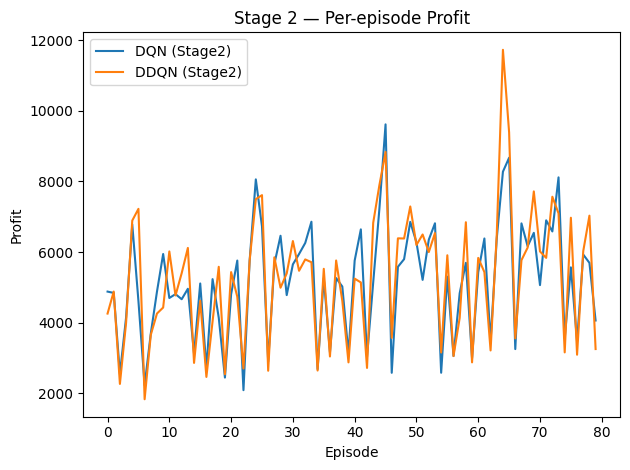

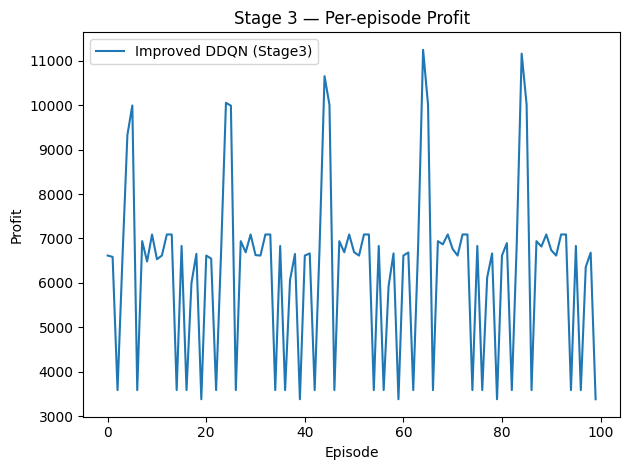

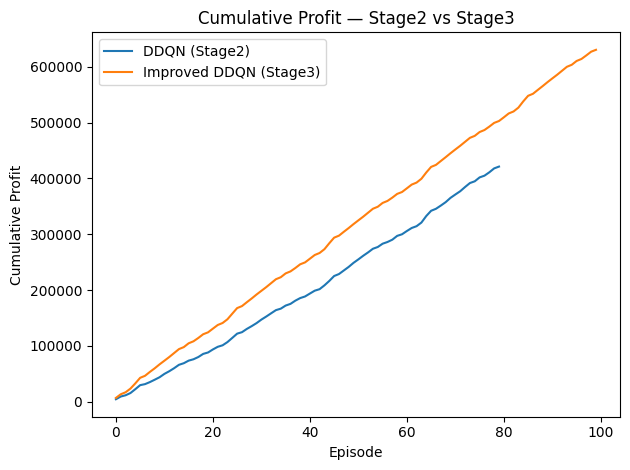

Saved metrics to results/stage2_vs_stage3_metrics.csv


In [10]:

# === Side-by-side comparison ===
comp = pd.concat([metrics_stage2.assign(stage="Stage2"), metrics_stage3.assign(stage="Stage3")], ignore_index=True)
display(comp)

# === Plots ===
import os
os.makedirs("plots", exist_ok=True)
os.makedirs("results", exist_ok=True)

# Stage 2 profit per episode
plt.figure()
plt.plot(res_van2["rewards"], label="DQN (Stage2)")
plt.plot(res_dd2["rewards"], label="DDQN (Stage2)")
plt.xlabel("Episode"); plt.ylabel("Profit"); plt.title("Stage 2 — Per-episode Profit"); plt.legend()
plt.tight_layout(); plt.savefig("plots/stage2_episode_profit.png", dpi=160); plt.show()

# Stage 3 profit per episode
plt.figure()
plt.plot(res_impr["rewards"], label="Improved DDQN (Stage3)")
plt.xlabel("Episode"); plt.ylabel("Profit"); plt.title("Stage 3 — Per-episode Profit"); plt.legend()
plt.tight_layout(); plt.savefig("plots/stage3_episode_profit.png", dpi=160); plt.show()

# Cumulative comparison (Stage2 DDQN vs Stage3 Improved)
def cum(x): return np.cumsum(x)
plt.figure()
plt.plot(cum(res_dd2["rewards"]), label="DDQN (Stage2)")
plt.plot(cum(res_impr["rewards"]), label="Improved DDQN (Stage3)")
plt.xlabel("Episode"); plt.ylabel("Cumulative Profit"); plt.title("Cumulative Profit — Stage2 vs Stage3"); plt.legend()
plt.tight_layout(); plt.savefig("plots/cum_profit_stage2_vs_stage3.png", dpi=160); plt.show()

# Export tables
comp.to_csv("results/stage2_vs_stage3_metrics.csv", index=False)
print("Saved metrics to results/stage2_vs_stage3_metrics.csv")
